In [1]:
# This notebook extracts the dopamine signal in response to choice (ipsi- and contralateral movement) and reward in the CoT task
# from mice which have been assessed for threat responses previously.

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%cd APE_paper/docs/figures_notebooks
!git checkout YvonneJohansson

In [5]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import urllib.request
from os.path import exists
import matplotlib.pylab as plt
import numpy as np
import pickle
from scipy.signal import decimate


import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
import os
sys.path.insert(1, os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))))
from scripts import YJ_analysis_utils as yj_utils
from scripts import yj_plotting as yj_plot

In [9]:
# Supplementary Figure 5F & 5G:

# Get dataset information:
dataset_name = 'DataOverview_SF5FG.csv'
zenodo = "https://zenodo.org/records/xxxxxxxxxxx/files/"
url = zenodo + dataset_name
dataset_path = '../../data/' + dataset_name
print(dataset_path)
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('DataOverview already in directory')

#print(dataset_path)
info = pd.read_csv(dataset_path)

../../data/DataOverview_SF5FG.csv
DataOverview already in directory


In [10]:
info

,Unnamed: 0,AnimalID,Date,fiber_side,protocol1,protocol2
0,1,TS24,20230920,right,SOR,NaN
1,2,TS26,20230918,right,SOR,NaN
2,3,TS33,20231102,right,SOR,NaN
3,4,TS34,20231030,right,SOR,NaN


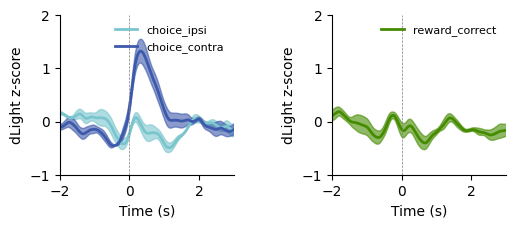

In [11]:
all_group_data = {'choice_contra': [],'choice_ipsi': [], 'reward_correct': []}
nr_mice = info.shape[0]

for i, mouse in enumerate(info['AnimalID']):
    date = str(info['Date'][i])
    fiber_side = info['fiber_side'][i]
    protocol = '2AC' # please note that only classic CoT trials are considered in this analysis and contralateral SOR trials are excluded.
    dataset_names = []
    CoT_trial_dataname = mouse + '_' + date + '_restructured_data.pkl'
    CoT_photo_dataname = mouse + '_' + date + '_smoothed_signal.npy' 
    dataset_names.extend([CoT_photo_dataname,CoT_trial_dataname])
    url = zenodo + dataset_name
    for j, dataset_name in enumerate(dataset_names): 
        dataset_path = '../../data/' + dataset_name
        if not exists(dataset_path):
            print('Downloading ' + dataset_name)
            urllib.request.urlretrieve(url, dataset_path)
        #else:
        #   print(dataset_name + ' already in directory')
        
        if j == 0:
            photometry_data = np.load(dataset_path)  
        if j == 1:  
            trial_data = pd.read_pickle(dataset_path)
            session_traces = yj_utils.SessionData(mouse, date, fiber_side, protocol, trial_data, photometry_data)
    
    alignements = ['choice', 'reward']
    for a, alignement in enumerate(alignements):
        if alignement == 'choice':
            curr_data = session_traces.choice
            curr_data_contra_mean = decimate(curr_data.contra_data.mean_trace, 10)
            curr_data_contra_time = decimate(curr_data.contra_data.time_points, 10)
            all_group_data[alignement + '_contra'].append(curr_data_contra_mean)
            curr_data_ipsi_mean = decimate(curr_data.ipsi_data.mean_trace, 10)
            curr_data_ipsi_time = decimate(curr_data.ipsi_data.time_points, 10)
            all_group_data[alignement + '_ipsi'].append(curr_data_ipsi_mean)
            time = curr_data_contra_time
            
        elif alignement == 'reward':
            curr_data = session_traces.reward 
            # combine correct ipsi and contra:
            correct_traces = np.concatenate((curr_data.contra_data.sorted_traces, curr_data.ipsi_data.sorted_traces), axis=0) 
            curr_data_correct_mean = decimate(np.mean(correct_traces, axis=0), 10)
            curr_data_correct_time = decimate(curr_data.contra_data.time_points, 10)
            all_group_data[alignement + '_correct'].append(curr_data_correct_mean)

figure = yj_plot.plot_SF5FG(all_group_data, time)

# uncomment here to save the plot
dataset_path = '../../data/'
plt.savefig(dataset_path + 'SFig5fg.png',
            transparent=True, bbox_inches='tight')